## Wizualizacja danych: Projekt 2
## Jakie cechy dobrze różnicują firmy, które kontynuują działalność gospodarczą w okresie 12 miesięcy od tych, które działalności nie kontynuują?
[zmienna Target]

In [62]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt; plt.style.use("fivethirtyeight")
import seaborn as sns

from sklearn.model_selection import train_test_split

from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer

from sklearn.linear_model import LogisticRegression

from sklearn.pipeline import Pipeline

import sys; sys.path.insert(0, '..')
from utils import evaluate

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

In [55]:
data = pd.read_csv("../data/ceidg_data_classif.csv")
print(data.shape)

x_train, x_test, y_train, y_test = train_test_split(data.drop("Target", axis=1), data["Target"], random_state=RANDOM_SEED)
x_train.head()

(2401055, 30)


,RandomDate,MonthOfStartingOfTheBusiness,QuarterOfStartingOfTheBusiness,MainAddressVoivodeship,MainAddressCounty,MainAddressTERC,CorrespondenceAddressVoivodeship,CorrespondenceAddressCounty,CorrespondenceAddressTERC,MainAndCorrespondenceAreTheSame,...,HasPolishCitizenship,ShareholderInOtherCompanies,PKDMainSection,PKDMainDivision,PKDMainGroup,PKDMainClass,NoOfUniquePKDSections,NoOfUniquePKDDivsions,NoOfUniquePKDGroups,NoOfUniquePKDClasses
1945399,2018-06-01,January,1,KUJAWSKO-POMORSKIE,GRUDZIąDZ,462011.0,KUJAWSKO-POMORSKIE,GRUDZIąDZ,462011.0,True,...,True,False,E,38.0,383.0,3832.0,5,8,8,10
365626,2018-09-29,February,1,LUBELSKIE,CHEłM,662011.0,LUBELSKIE,CHEłM,662011.0,True,...,True,False,G,45.0,451.0,4511.0,1,1,1,1
592516,2017-12-04,May,2,POMORSKIE,GDAńSKI,2204011.0,POMORSKIE,GDAńSKI,2204011.0,True,...,True,False,G,47.0,472.0,4721.0,1,1,3,4
1081769,2018-07-04,September,3,WIELKOPOLSKIE,LESZNO,3063011.0,WIELKOPOLSKIE,LESZNO,3063011.0,True,...,True,False,G,47.0,478.0,4782.0,1,1,2,4
1380143,2018-03-23,May,2,MAZOWIECKIE,OSTROłęCKI,1415085.0,MAZOWIECKIE,OSTROłęCKI,1415085.0,True,...,True,False,G,46.0,464.0,4642.0,1,1,1,1


List of features with explanation:

- **RandomDate**: Randomly chose date beetween 01-11-2017 and 01-11-2018 (or date of termination or suspension if continuity of the Business were stopped earlier in this period).
- **Target**: The binary response variable indicates if continuity of the business was broken in **12 months from random date**. 
- **MonthOfStartingOfTheBusiness**: The month of registering a business in the CEIDG registry.
- **QuarterOfStartingOfTheBusiness**: The quarter of registering a business in the CEIDG registry.
- **MainAddressVoivodeship**.
- **MainAddressCounty**.
- **MainAddressTERC: Helper column.** [TERC Code](https://pl.wikipedia.org/wiki/TERC). May be used for data enhacement form other data sources (eg. GUS BDL via **[R_Package_to_API_BDL](https://github.com/statisticspoland/R_Package_to_API_BDL)**).
- **CorrespondenceAddressVoivodeship**.
- **CorrespondenceAddressCounty**.
- **CorrespondenceAddressTERC: Helper column.** [TERC Code](https://pl.wikipedia.org/wiki/TERC). May be used for data enhacement form other data sources (eg. GUS BDL via **[R_Package_to_API_BDL](https://github.com/statisticspoland/R_Package_to_API_BDL)**). 
- **MainAndCorrespondenceAreTheSame**: Checking if the correspondence address and the main address are the same (with an accuracy to the street).
- **DurationOfExistenceInMonths**: Time in months from registering of the business to **RandomDate** (results has been rounded down to the nearest integer). 
- **NoOfAdditionalPlaceOfTheBusiness**.
- **IsPhoneNo**: Checking if the phone number has been filled in the register (filling in the field is optional).
- **IsEmail**: Checking if the email has been filled in the register (filling in the field is optional).
- **IsWWW**: Checking if the web address has been filled in the register (filling in the field is optional).
- **CommunityProperty**: 
- **HasLicences**: Checking if the business is running with special permissions (eg. sale of alcohol, transportation of people).
- **NoOfLicences**.
- **Sex**: Variable has been created by checking the last letter of a name. If the last letter is 'a' then sex is defined as female, otherwise as male. The disadvantage of this approach is the possibility of not classifying foreigners correctly.
- **HasPolishCitizenship**.
- **ShareholderInOtherCompanies**.

Features listed below based on [Polska Klasyfikacja Działalności](https://www.biznes.gov.pl/en/classification-pkd-code)

- **PKDMainSection**.
- **PKDMainDivision**.
- **PKDMainGroup**.
- **PKDMainClass**.
- **NoOfUniquePKDSections**.
- **NoOfUniquePKDDivsions**.
- **NoOfUniquePKDGroups**.
- **NoOfUniquePKDClasses**.

---
### Data exploration

In [83]:
print("Percentage of companies that failed after 12 months: {:.2f}%".format(y_train.mean()*100))

Percentage of companies that failed after 12 months: 17.22%


In [84]:
data.columns

Index(['RandomDate', 'MonthOfStartingOfTheBusiness',
       'QuarterOfStartingOfTheBusiness', 'MainAddressVoivodeship',
       'MainAddressCounty', 'MainAddressTERC',
       'CorrespondenceAddressVoivodeship', 'CorrespondenceAddressCounty',
       'CorrespondenceAddressTERC', 'MainAndCorrespondenceAreTheSame',
       'DurationOfExistenceInMonths', 'NoOfAdditionalPlaceOfTheBusiness',
       'IsPhoneNo', 'IsEmail', 'IsWWW', 'CommunityProperty', 'HasLicences',
       'NoOfLicences', 'Sex', 'HasPolishCitizenship',
       'ShareholderInOtherCompanies', 'PKDMainSection', 'PKDMainDivision',
       'PKDMainGroup', 'PKDMainClass', 'NoOfUniquePKDSections',
       'NoOfUniquePKDDivsions', 'NoOfUniquePKDGroups', 'NoOfUniquePKDClasses',
       'Target'],
      dtype='object')

In [85]:
data["CommunityProperty"]  # some NANs that are represented as '-'

0            -
1          nie
2            -
3          nie
4          tak
          ... 
2401050    nie
2401051    tak
2401052      -
2401053    nie
2401054      -
Name: CommunityProperty, Length: 2401055, dtype: object

#### Missing values
Strategy: fill NAs with "unkown" value for categorial variables. Numerical and boolean variables don't have NAs.

In [86]:
data.isna().mean()

RandomDate                          0.000000
MonthOfStartingOfTheBusiness        0.000000
QuarterOfStartingOfTheBusiness      0.000000
MainAddressVoivodeship              0.029430
MainAddressCounty                   0.029453
MainAddressTERC                     0.030117
CorrespondenceAddressVoivodeship    0.058200
CorrespondenceAddressCounty         0.059082
CorrespondenceAddressTERC           0.077754
MainAndCorrespondenceAreTheSame     0.000000
DurationOfExistenceInMonths         0.000000
NoOfAdditionalPlaceOfTheBusiness    0.000000
IsPhoneNo                           0.000000
IsEmail                             0.000000
IsWWW                               0.000000
CommunityProperty                   0.000000
HasLicences                         0.000000
NoOfLicences                        0.000000
Sex                                 0.000000
HasPolishCitizenship                0.000000
ShareholderInOtherCompanies         0.000000
PKDMainSection                      0.015283
PKDMainDiv

In [87]:
data.dtypes

RandomDate                           object
MonthOfStartingOfTheBusiness         object
QuarterOfStartingOfTheBusiness        int64
MainAddressVoivodeship               object
MainAddressCounty                    object
MainAddressTERC                     float64
CorrespondenceAddressVoivodeship     object
CorrespondenceAddressCounty          object
CorrespondenceAddressTERC           float64
MainAndCorrespondenceAreTheSame        bool
DurationOfExistenceInMonths           int64
NoOfAdditionalPlaceOfTheBusiness      int64
IsPhoneNo                              bool
IsEmail                                bool
IsWWW                                  bool
CommunityProperty                    object
HasLicences                            bool
NoOfLicences                          int64
Sex                                  object
HasPolishCitizenship                   bool
ShareholderInOtherCompanies            bool
PKDMainSection                       object
PKDMainDivision                 

In [88]:
categorical_variables = ["MonthOfStartingOfTheBusiness", "MainAddressVoivodeship", "PKDMainSection",  "Sex"]
numerical_variables = [
    "MainAndCorrespondenceAreTheSame", 
    "DurationOfExistenceInMonths", 
    "NoOfAdditionalPlaceOfTheBusiness",
    "IsPhoneNo",
    "IsEmail",
    "IsWWW",
#     "HasLicences",  # useless since we have NoOfLicenses
    "NoOfLicences",
    "HasPolishCitizenship",
    "ShareholderInOtherCompanies"
]

impute_encode = Pipeline([
    ("impute", SimpleImputer(strategy="constant", fill_value="unknown")),
    ("one_hot_enocde", OneHotEncoder(handle_unknown="ignore"))
])

column_transformer = ColumnTransformer([
    ("one_hot_encoder", impute_encode , categorical_variables),
#     ("numerical_variables", MinMaxScaler(), numerical_variables)
    ])


pipeline = Pipeline([
    ("get_features", column_transformer),
    ("predict", LogisticRegression(max_iter=1000, tol=1e-5, C=1))
])

In [89]:
pipeline.fit(x_train, y_train);

Accuracy: 82.76
F-1 score: 0.0000


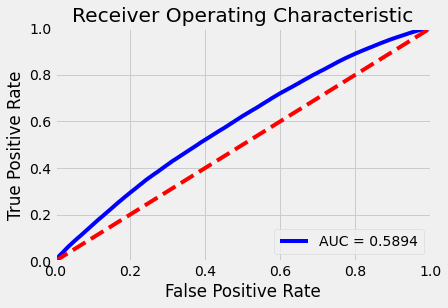

0.589446523348124

In [90]:
evaluate(pipeline, x_test, y_test)